In [ ]:
!pip install -q "tensorflow==2.11.*"
!pip install -q "tensorflow_io==0.28.*"

In [107]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_io as tfio

In [103]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [134]:
_ = tf.keras.utils.get_file('car.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',

                        cache_dir='./',
                        cache_subdir='mass',
                        extract=True)

Exception: URL fetch failure on https://github.com/Boden448/Sound/archive/main.zip: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)

In [130]:
metadata_file_path='./mass/Sound-main/meta/DOA.csv'
data_dir='./mass/Sound-main/DOA_audio/'

In [131]:
metadata_df = pd.read_csv(metadata_file_path)
metadata_df.head()

,filename,fold,theta,x,z
0,./mass/Sound-main/DOA_audio/theta0x500z000.wav...,1,0,500,0
1,./mass/Sound-main/DOA_audio/theta5x498z044.wav...,1,5,498,44
2,./mass/Sound-main/DOA_audio/theta10x492z087.wa...,1,10,492,87
3,./mass/Sound-main/DOA_audio/theta15x483z129.wa...,1,15,483,129
4,./mass/Sound-main/DOA_audio/theta20x470z171.wa...,1,20,470,171


In [132]:
updated_metadata = []


with open(metadata_file_path, "r") as file:

    # create a CSV reader object
    reader = csv.DictReader(file)

    # loop through each row in the metadata file
    for row in reader:

        # get the filename from the current row
        filename = row["filename"]

        # construct the path to the corresponding WAV file
        wav_path = os.path.join(data_dir, filename + ".wav")

        # update the filename column with the path to the WAV file
        row["filename"] = wav_path

        # add the updated row to the list of updated metadata
        updated_metadata.append(row)
        
with open(metadata_file_path, "w") as file:

    # create a CSV writer object
    writer = csv.DictWriter(file, fieldnames=reader.fieldnames)

    # write the updated metadata to the metadata file
    writer.writeheader()
    writer.writerows(updated_metadata)
    


In [111]:
headers = metadata_df.columns.tolist()

In [99]:
wav_files = metadata_df['wav_file'].tolist() # assuming the metadata file has a column named "wav_file" containing the paths to the WAV files
sample_rate = 16000 # change this to the sample rate of your WAV files

features = []

for wav_file in wav_files:
    wav_file_path = "/path/to/wav/files/" + wav_file # change this to the path of your WAV files
    wav_data, _ = librosa.load(wav_file_path, sr=sample_rate, mono=True)
    mfccs = librosa.feature.mfcc(wav_data, sr=sample_rate, n_mfcc=13)
    features.append(mfccs.T.tolist())


KeyError: 'wav_file'

In [82]:
def create_dataset(metadata):
    # Load WAV files and extract features
    features = []
    for file_path in metadata['file_path']:
        feature = load_audio(file_path)
        features.append(feature)
    features = np.array(features)
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((features, metadata['label']))
    return dataset

In [83]:
train_metadata = metadata[metadata['split'] == 'train']
test_metadata = metadata[metadata['split'] == 'test']
train_dataset = create_dataset(train_metadata)
test_dataset = create_dataset(test_metadata)

KeyError: 'split'

In [75]:
def preprocess_dataset(audio_file_path, label):
    # Get the full path of the wav file
    wav_file_path = os.path.join(wav_dir, audio_file_path.numpy().decode('utf-8'))
    # Load and process the wav file
    spectrogram = process_wav_file(wav_file_path)
    return spectrogram, label

In [76]:
dataset = dataset.map(preprocess_dataset)

AttributeError: in user code:

    File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_31680\3226344565.py", line 3, in preprocess_dataset  *
        wav_file_path = os.path.join(wav_dir, audio_file_path.numpy().decode('utf-8'))

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 513)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [78]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [79]:
model.fit(dataset.batch(32), epochs=10)

Epoch 1/10


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [15]:
for i in range(1):
    history = my_model.fit(train_ds,
                           epochs=400,
                           validation_data=val_ds,
                           callbacks=callback)
    


Epoch 1/400
9/9 [==============================] - 7s 213ms/step - loss: 2.1915 - accuracy: 0.3584
Epoch 2/400
9/9 [==============================] - 0s 19ms/step - loss: 2.1773 - accuracy: 0.6166
Epoch 3/400
9/9 [==============================] - 0s 16ms/step - loss: 2.1628 - accuracy: 0.7399
Epoch 4/400
9/9 [==============================] - 0s 18ms/step - loss: 2.1472 - accuracy: 0.7707
Epoch 5/400
9/9 [==============================] - 0s 16ms/step - loss: 2.1292 - accuracy: 0.7977
Epoch 6/400
9/9 [==============================] - 0s 16ms/step - loss: 2.1083 - accuracy: 0.8304
Epoch 7/400
9/9 [==============================] - 0s 15ms/step - loss: 2.0844 - accuracy: 0.8420
Epoch 8/400
9/9 [==============================] - 0s 16ms/step - loss: 2.0581 - accuracy: 0.8555
Epoch 9/400
9/9 [==============================] - 0s 15ms/step - loss: 2.0305 - accuracy: 0.8536
Epoch 10/400
9/9 [==============================] - 0s 15ms/step - loss: 2.0020 - accuracy: 0.8362
Epoch 11/400
9/9 [

9/9 [==============================] - 0s 14ms/step - loss: 0.4128 - accuracy: 0.9942
Epoch 166/400
9/9 [==============================] - 0s 13ms/step - loss: 0.4094 - accuracy: 0.9942
Epoch 167/400
9/9 [==============================] - 0s 13ms/step - loss: 0.4060 - accuracy: 0.9942
Epoch 168/400
9/9 [==============================] - 0s 14ms/step - loss: 0.4026 - accuracy: 0.9942
Epoch 169/400
9/9 [==============================] - 0s 13ms/step - loss: 0.3993 - accuracy: 0.9942
Epoch 170/400
9/9 [==============================] - 0s 14ms/step - loss: 0.3960 - accuracy: 0.9942
Epoch 171/400
9/9 [==============================] - 0s 14ms/step - loss: 0.3928 - accuracy: 0.9942
Epoch 172/400
9/9 [==============================] - 0s 14ms/step - loss: 0.3895 - accuracy: 0.9942
Epoch 173/400
9/9 [==============================] - 0s 14ms/step - loss: 0.3864 - accuracy: 0.9942
Epoch 174/400
9/9 [==============================] - 0s 14ms/step - loss: 0.3832 - accuracy: 0.9942
Epoch 175/400


9/9 [==============================] - 0s 14ms/step - loss: 0.2186 - accuracy: 0.9961
Epoch 248/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2172 - accuracy: 0.9961
Epoch 249/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2157 - accuracy: 0.9961
Epoch 250/400
9/9 [==============================] - 0s 13ms/step - loss: 0.2142 - accuracy: 0.9961
Epoch 251/400
9/9 [==============================] - 0s 13ms/step - loss: 0.2127 - accuracy: 0.9961
Epoch 252/400
9/9 [==============================] - 0s 13ms/step - loss: 0.2113 - accuracy: 0.9961
Epoch 253/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2098 - accuracy: 0.9961
Epoch 254/400
9/9 [==============================] - 0s 13ms/step - loss: 0.2084 - accuracy: 0.9961
Epoch 255/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2070 - accuracy: 0.9961
Epoch 256/400
9/9 [==============================] - 0s 14ms/step - loss: 0.2056 - accuracy: 0.9961
Epoch 257/400


9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.9981
Epoch 330/400
9/9 [==============================] - 0s 13ms/step - loss: 0.1246 - accuracy: 0.9981
Epoch 331/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1238 - accuracy: 0.9981
Epoch 332/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1231 - accuracy: 0.9981
Epoch 333/400
9/9 [==============================] - 0s 13ms/step - loss: 0.1223 - accuracy: 0.9981
Epoch 334/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1216 - accuracy: 0.9981
Epoch 335/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1209 - accuracy: 0.9981
Epoch 336/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1201 - accuracy: 0.9981
Epoch 337/400
9/9 [==============================] - 0s 14ms/step - loss: 0.1194 - accuracy: 0.9981
Epoch 338/400
9/9 [==============================] - 0s 13ms/step - loss: 0.1187 - accuracy: 0.9981
Epoch 339/400


In [16]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [17]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

215546/215546 [==============================] - 0s 1us/step
./test_data\miaow_16k.wav


In [18]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [19]:
saved_model_path = './dogs_cos_pigs'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


In [20]:
reloaded_model = tf.saved_model.load(saved_model_path)

./madds/Sound-main/photo/start6.wav


Waveform values: [ 9.1317332e-08 -1.3649588e-07 -2.2615909e-06 ... -2.0208061e-02
 -1.2977615e-02 -1.6084276e-02]


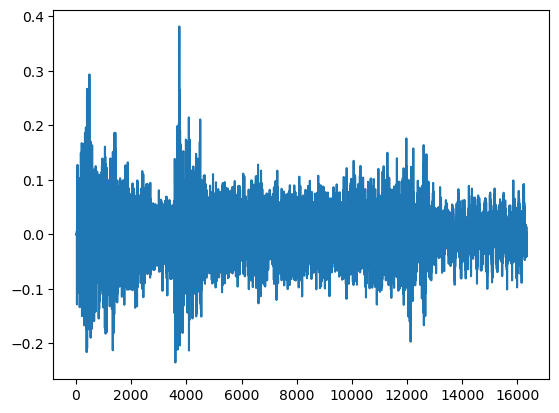

In [21]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 1]
row = test_pd.sample(1)
risk = row['risk'].item()
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [22]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
print(f'risk level: {risk}')

[Your model] The main sound is: start (0.930091917514801)
risk level: low
